In [34]:
from os import system
import os
import pandas as pd
import numpy as np
import time
import copy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import graphviz
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score

# Data Preprocessing (No need to use in case of pickle load)

In [2]:
data1 = pd.read_csv('dataset/flight.csv')
data2 = pd.read_csv('dataset/flight_littleone.csv')
data3 = pd.read_csv('dataset/flight_mustafa.csv')
data4 = pd.read_csv('dataset/flight_ubuntu.csv')
frames = [data1, data2, data3, data4]
result = pd.concat(frames)
N_B1 = np.sum(result["controller_ID"] == "Backstepping_1")
N_B2 = np.sum(result["controller_ID"] == "Backstepping_2")
N_B3 = np.sum(result["controller_ID"] == "Backstepping_3")
N_B4 = np.sum(result["controller_ID"] == "Backstepping_4")

print("Veriseti boyutu: ", result.shape)
print("Backstepping_1 oranı: %", N_B1/(N_B1+N_B2+N_B3+N_B4)*100)
print("Backstepping_2 oranı: %", N_B2/(N_B1+N_B2+N_B3+N_B4)*100)
print("Backstepping_3 oranı: %", N_B3/(N_B1+N_B2+N_B3+N_B4)*100)
print("Backstepping_4 oranı: %", N_B4/(N_B1+N_B2+N_B3+N_B4)*100)

Veriseti boyutu:  (11035, 30)
Backstepping_1 oranı: % 7.16810149524241
Backstepping_2 oranı: % 47.449025826914365
Backstepping_3 oranı: % 16.683280471227913
Backstepping_4 oranı: % 28.699592206615314


In [3]:
N_Test = 1000
dataset = result.values
controller_labels = {'Backstepping_1': 0, 'Backstepping_2': 1, 'Backstepping_3': 2, 'Backstepping_4': 3}
np.random.shuffle(dataset)
y = np.array([controller_labels[data[-1]] for data in dataset]).reshape(-1,)
X = dataset[:,:-1]

X_test = X[0:N_Test,:]
y_test = y[0:N_Test]

X_train, X_val, y_train, y_val = train_test_split(X[N_Test:,:], y[N_Test:], test_size=0.15, random_state=42)

# Saving the objects:
# with open('dataset.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([X_train, X_val, X_test, y_train, y_val, y_test], f)
    
pickle.dump([X_train, X_val, X_test, y_train, y_val, y_test], open("dataset.pkl","wb"), protocol=2)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print ("X_train boyutu: ",X_train.shape)
print ("X_val boyutu: ",X_val.shape)
print ("X_test boyutu: ",X_test.shape)

X_train boyutu:  (8529, 29)
X_val boyutu:  (1506, 29)
X_test boyutu:  (1000, 29)


# Data Loading

In [ ]:
with open('dataset.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

# Decision Tree Design

Decision Tree Train Acc: 0.762, Val Acc: 0.763, Test Acc: 0.754
Random Forest Train Acc: 0.988, Val Acc: 0.959, Test Acc: 0.953


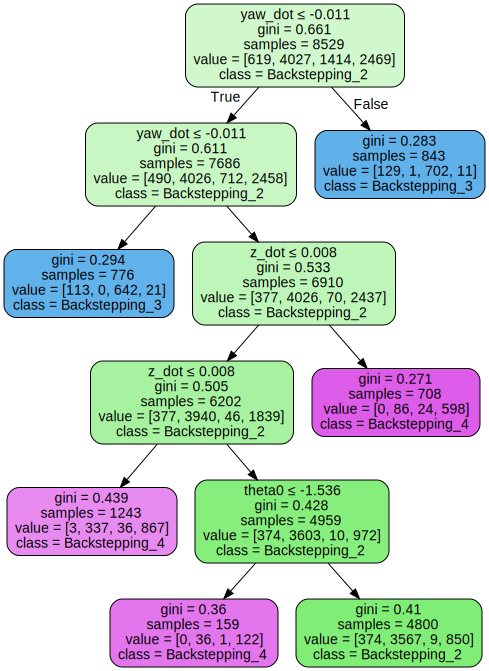

In [4]:
from sklearn.tree._tree import TREE_LEAF

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)


feature_names = ['pos_diffx','pos_diffy','pos_diffz', 'x_dot0','y_dot0','z_dot0', 'x_ddot0','y_ddot0','z_ddot0', 'phi0','theta0','yaw0', 'phi_dot0','theta_dot0','yaw_dot0', 
                 'x','y','z','x_dot','y_dot','z_dot', 'phi','theta','yaw', 'phi_dot','theta_dot','yaw_dot', 'Tf', 'Cost']

class_names = ['Backstepping_1', 'Backstepping_2', 'Backstepping_3', 'Backstepping_4']
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
prune_index(clf.tree_, 0, 10)

train_pred = clf.predict(X_train)
val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)


train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)

print ("Decision Tree Train Acc: {0:.3}, Val Acc: {1:.3}, Test Acc: {2:.3}".format(train_acc, val_acc, test_acc))


forest = RandomForestClassifier(bootstrap=True, n_estimators=100, 
                                min_samples_split=12, min_samples_leaf=5, max_features=10, max_depth=80)
forest = forest.fit(X_train, y_train)

train_pred = forest.predict(X_train)
val_pred = forest.predict(X_val)
test_pred = forest.predict(X_test)


train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)

print ("Random Forest Train Acc: {0:.3}, Val Acc: {1:.3}, Test Acc: {2:.3}".format(train_acc, val_acc, test_acc))

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=feature_names,  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data) 
graph

# Neural Network Design

In [61]:
stats_columns = ['Layers', 'Epochs', 'BatchSize', 'LearningRate', 'Optimizer', 'Scheduler', 'TrainAcc', 'ValAcc']
stats_filename = 'params_results.csv'

def write_results(results): 
    df_stats = pd.DataFrame([results], columns=stats_columns)
    df_stats.to_csv(stats_filename, mode='a', index=False,header=not os.path.isfile(stats_filename))

def predict(X, y, model):
    #Validation part
    model.eval()  # Set model to training mode

    inputs, labels = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device).long()

    outputs = model(inputs.float())
    _, preds = torch.max(outputs, 1)

    loss = criterion(outputs, labels)
    
    accuracy = torch.sum(preds == labels.data).item() / float(inputs.size(0))
    
    print ("Test data, Loss: {0:.3}, Accuracy: {1:.4}".format(loss.item(), accuracy))
    

def shuffle_dataset(X, y):
    p = np.random.permutation(len(X))
    return X[p], y[p]

def train_model(X, y, X_val, y_val, model, criterion, optimizer, scheduler, minibatch_size, num_epochs=25):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    losses_train = []
    losses_val = []
    accuracy_train = []
    accuracy_val = []
    # path = F"/content/drive/My Drive/best_model.pt"
#     directory = path_name

#     if not os.path.exists(directory):
#         os.makedirs(directory)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        X_train, y_train = shuffle_dataset(X, y)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        losses_iter = []
        accuracy_iter = []

        # Iterate over data.
        for i in range(0, X_train.shape[0], minibatch_size):
            # Get pair of (X, y) of the current minibatch/chunk             
            X_batch = X_train[i:i + minibatch_size]
            y_batch = y_train[i:i + minibatch_size]

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = torch.from_numpy(X_batch).to(device), torch.from_numpy(y_batch).to(device).long()


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs.float())
                _, preds = torch.max(outputs, 1)
                
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
            
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # print ("losses_iter", loss.item() * inputs.size(0))
            # print ("accuracy_iter", torch.sum(preds == labels.data).item() / float(inputs.size(0)))

            losses_iter.append(loss.item())
            accuracy_iter.append(torch.sum(preds == labels.data).item() / float(inputs.size(0)))
        
            scheduler.step()
        
        train_loss = np.mean(losses_iter)
        train_acc = np.mean(accuracy_iter)

        losses_train.append(train_loss)
        accuracy_train.append(train_acc)


        print('Training Loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc))
        
        #Validation part
        model.eval()  # Set model to training mode
        
        inputs, labels = torch.from_numpy(X_val).to(device), torch.from_numpy(y_val).to(device).long()
        
        optimizer.zero_grad()
        
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        
        val_loss = loss.item()
        val_acc = torch.sum(preds == labels.data).item() / float(inputs.size(0))
        
        losses_val.append(val_loss)
        accuracy_val.append(val_acc)
        
        
        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))

#         deep copy the model
        if val_acc > best_acc:
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            path = "best_model.pt"
            torch.save(best_model_wts, path)

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}s'.format(time_elapsed))
    print('Best Train Acc: {:4f}'.format(best_train_acc))
    print('Best Val Acc: {:4f}'.format(best_val_acc))
    
    
#     stats_columns = ['Layers', 'Epochs', 'BatchSize', 'LearningRate', 'Optimizer', 'Scheduler', 'TrainAcc', 'ValAcc']
    layers = [module for module in model.modules() if type(module) != nn.Sequential]
    write_results([layers, num_epochs, minibatch_size, learning_rate, optimizer.state_dict, scheduler.state_dict, best_train_acc, best_val_acc])

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [62]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop_layer = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(29, 800)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, 200)
        self.fc4 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc2(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc3(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc4(x))
        x = self.drop_layer(x)
        x = self.fc5(x)
        return x

n_epochs = 1
minibatch_size = 16
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, X_train.shape[0], eta_min=learning_rate)
final_mode = train_model(X_train, y_train, X_val, y_val, model, criterion, optimizer, scheduler, minibatch_size, num_epochs=n_epochs)

Epoch 0/0
----------
Training Loss: 1.1666 Acc: 0.4855
Validation Loss: 1.1124 Acc: 0.5060

Training complete in 5s
Best Train Acc: 0.485487
Best Val Acc: 0.505976


In [ ]:
predict(X_test, y_test, model)

# SVM

In [ ]:
svc = svm.SVC(kernel='rbf')
svc.fit(X_train, y_train)

svc = svc.fit(X_train, y_train)

train_pred = svc.predict(X_train)
val_pred = svc.predict(X_val)
test_pred = svc.predict(X_test)


train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)

print ("SVM Train Acc: {0:.3}, Val Acc: {1:.3}, Test Acc: {2:.3}".format(train_acc, val_acc, test_acc))